In [7]:
from tifffile import TiffFile
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from scipy import optimize
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import binary_opening, binary_closing
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func

save_folder = '.'
import skimage

from alienlab.plot import PlotFigure
p = PlotFigure()
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"
p.extension = ".pdf"

from skimage.filters import try_all_threshold

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

In [8]:
import matplotlib
cvals  = [-2., -1,0, 1, 2]
colors = ["w","darkblue","royalblue", 'cornflowerblue', 'lightblue']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
blue_map = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)



In [9]:
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0

def residuals(parameters, x_data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed


def simple_tau(fluo, time_array, sample_rate = 0):
    L = len(time_array) 
    if sample_rate==0:
        sample_rate = L/(time_array[-1]-time_array[0])
    fluo_transition = fluo
    time_transition = np.linspace(0, L - 1, L)
    x0 = [fluo.max(), L/2, fluo.min()]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition, fluo_transition, exp_decay))
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]

    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  L//10: #if too high
        tau =  L//10
    if tau < 3: #if too low, increase it
        tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
    parameters_estimated = OptimizeResult.x
    parameters_estimated[1]/=sample_rate

    return parameters_estimated


@delayed
@wrap_non_picklable_objects
def simple_tau_parallel(fluo, time_array, sample_rate = 5):
    return simple_tau(fluo, time_array, sample_rate)[1]

def read_lsm(file):

    with TiffFile(file) as tif:
        volume = tif.asarray()
        #axes = tif.series[0].axes
        lsm_metadata = tif.lsm_metadata
    time = lsm_metadata["TimeStamps"]
    dwell_time = lsm_metadata["ScanInformation"]["Tracks"][0]["PixelTime"]*1e-6
    H = lsm_metadata["DimensionX"]
    zoom  = lsm_metadata['ScanInformation']["ZoomX"]
    intensity = lsm_metadata['ScanInformation']['Tracks'][0]['IlluminationChannels'][0]['Power']

    dx = lsm_metadata["VoxelSizeX"]
    return volume, time, dwell_time, lsm_metadata, zoom, dx, intensity, H

def file_analyse(file, plot = False):
    volume, time, dwell_time, lsm_metadata = read_lsm(file)
    time -= time[0]
    intensity = lsm_metadata['ScanInformation']['Tracks'][0]['IlluminationChannels'][0]['Power']
    if len(volume.shape)==3:
        
        threshold = skimage.filters.thresholding.threshold_yen(volume[0])
        mask = volume[0]>0#threshold
        #plt.figure()
        #plt.imshow(mask)
        for i in range(len(volume)):
            volume[i] = volume[i]*mask
        fluo = np.mean(volume, axis = (1,2))

            
        
    else:
        fluo = volume
        
        
    params = simple_tau(fluo/fluo[0], time, sample_rate = 1)#/dwell_time)
    if plot:
        #plt.figure()
        plt.plot(time, fluo/fluo[0], '-')
        
        plt.plot(time, exp_decay(params, time))
        
    return params[1], intensity



  
def plot_map(I_000, I_000_map, save_name, limits = (0,0), tau = False):
    """display the results"""
    
    #crop the outliers for correct scaling of the colormap
    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.05)
        Q3 = np.quantile(I_000, 0.95)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    
    
    #map of intensities
    f = p.set_figure()
    if tau == False:
        image = plt.imshow((I_000_map), cmap = blue_map)
        
    else:
        image = plt.imshow((I_000_map), cmap = "viridis")
        
        
    L, H = I_000_map.shape
    scale = H//6
    rec = matplotlib.patches.Rectangle((H-H//5, L-L//11), scale, L//100, color = "lightgrey")
    ax = plt.gca()
    ax.add_patch(rec)
        
    plt.axis("off")
    divider = make_axes_locatable(plt.gca())
    axdef = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
    ax = plt.gca()
    ax.tick_params(labelsize=p.fonttick)
    if tau==False:
        plt.xlabel(p.label_intensity, size = p.fontsize)
    else:
        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)",  size = p.fontsize)

    plt.savefig(p.save_folder + "/" +save_name + p.extension)
    
    
    # histogram of intensities
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()

    
    if tau==False:
        fig = p.set_figure("%d", "%d")

        plt.xlabel(p.label_intensity)
    else:
        fig = p.set_figure("%0.1f", "%d")

        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)")
    ax = plt.gca()

    plt.ylabel("")
    ax.tick_params(axis='both', which='major', direction = 'in', top = True, right = True)
    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    plt.savefig(p.save_folder + "/hist_" + save_name + p.extension)
    
    np.savetxt(p.save_folder + "/" + save_name + ".csv", I_000_map, delimiter=",")


    return I_000_map, I_000_distrib


In [10]:
D=4

power_ENS 8.242424242424241e-06 1.0 1.6605316419276782e-06 10.0 256 126.23917157702789
power_ENS 8.242424242424241e-06 2.0 8.302658209638391e-07 10.0 256 90.62878027311942


C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


power_ENS 8.242424242424241e-06 2.5 6.642126567710712e-07 10.0 256 63.84553585945544
power_ENS 8.242424242424241e-06 3.0 5.53510547309226e-07 10.0 256 52.75033799673016


C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


power_ENS 8.242424242424241e-06 3.5 4.744376119793366e-07 10.0 256 41.7786475719779
power_ENS 8.242424242424241e-06 4.0 4.1513291048191956e-07 10.0 256 33.86346827591255


C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


power_ENS 8.242424242424241e-06 4.5 3.6900703153948404e-07 10.0 256 27.555786235392915
power_ENS 8.242424242424241e-06 5.0 3.321063283855356e-07 10.0 256 23.72752965984767


C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


power_ENS 8.242424242424241e-06 5.5 3.019148439868506e-07 10.0 256 20.39314011466649
power_ENS 8.242424242424241e-06 6.0 2.76755273654613e-07 10.0 256 17.123715307217633
power_ENS 8.242424242424241e-06 2.0 8.302658209638391e-07 10.0 256 86.06884322621453
power_ENS 8.242424242424241e-06 4.0 4.1513291048191956e-07 10.0 256 34.62992813488097


C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
C:\Users\Alienor\AppData\Local\Temp\ipykernel_11392\3053518785.py:9: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


power_ENS 8.242424242424241e-06 4.0 4.1513291048191956e-07 10.0 256 33.69249439785273


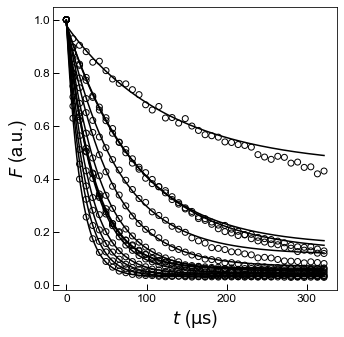

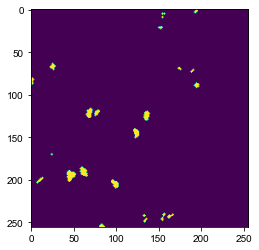

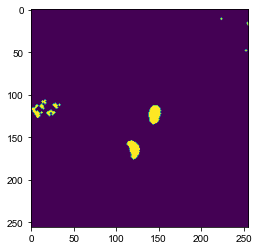

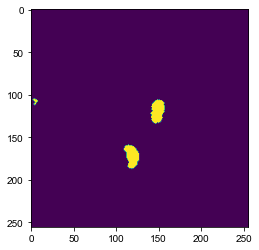

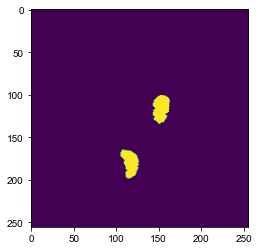

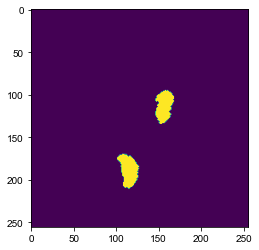

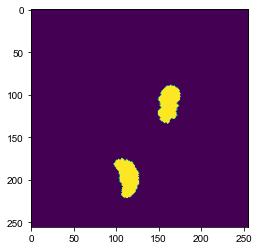

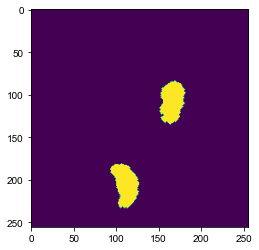

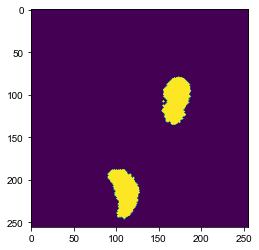

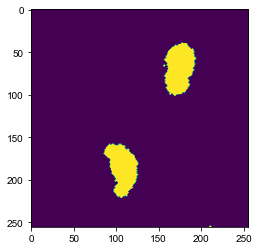

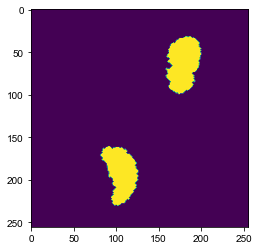

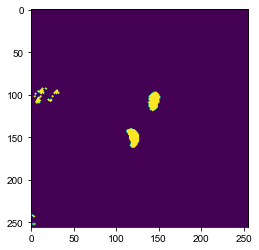

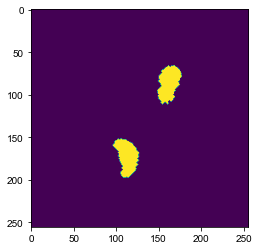

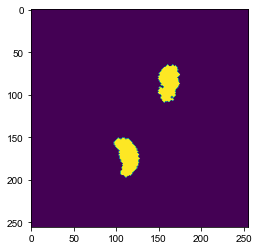

In [11]:
fig = p.set_figure("%d", "%0.1f")
ax = plt.gca()
plt.xlabel('$t$ ($\mathrm{\mu s}$)')
plt.ylabel("$F$ (a.u.)")

save_folder = "../images"
extension = ".png"

zoom  = []
taus = []
dwell = []
inty = []
vox = []
Hs = []

folder = glob.glob( "../data/confocalENS_v3/confocal_3/serie2/*.lsm") + glob.glob("../data/confocalENS_v2/221104_Manips_Confocal/Manips_Confocal/*.lsm") + glob.glob( "../data/confocalENS_v1/D2-H2B/*.lsm") + glob.glob( "../data/confocalENS_v1/D2-Solution/*.lsm")

#for i, j in enumerate(range(55, 100)): #intenisty effect
for i, j in enumerate(range(9,  35)): #Zoom
#for i, j in enumerate(range(0,  100)):

    file = folder[j]

    if "405" not in file: 
        #print(file)
        name = "%d_"%i + os.path.split(file)[1][:-4]
        volume, time, dwell_time, lsm_metadata, z, dx, intensity, H = read_lsm(file)


        start = 0

        #fit on the mean value before performing the fit on each pixel


        timing= np.linspace(0, len(time)-1, len(time))*dwell_time

        framerate = 1/dwell_time



        threshold = skimage.filters.thresholding.threshold_otsu(volume[0])
        mask = volume[0] > threshold
        mask = binary_opening(mask)
        mask = binary_closing(mask)
        
        if "Solution" in file:
            ddx = lsm_metadata["DimensionX"]
            dy  = lsm_metadata["DimensionY"]
            px = lsm_metadata["VoxelSizeX"]
            S = 6*1e-6//px + 1
            mask = np.zeros((volume[0].shape))
            V = D
            mask[int(ddx//V-S//V):int(ddx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
            mask = mask.astype(bool)
        plt.figure()
        plt.imshow(mask)

        volume = volume.reshape(volume.shape[0], -1)
        to_evaluate = volume[:,mask.flatten()]
        fluo = np.mean(to_evaluate, axis = (1))


        fluo/=fluo[0]
       

        if len(timing)>1 and i not in range(35, 50):# and intensity==5.0:
            params = simple_tau(fluo, timing, sample_rate = framerate)
            zoom.append(lsm_metadata["ScanInformation"]["ZoomX"])
            dwell.append(dwell_time)
            ax.scatter(timing*1e6, fluo, marker = "o", edgecolor = "k", facecolor="none", label = "raw data")
            x2 = np.linspace(timing.min(), timing.max(), 1024)
            ax.plot(x2*1e6, exp_decay(params, x2), "k",  label = "fit")

            taus.append(params[1])
            Hs.append(H)

            inty.append(intensity)
            vox.append(dx)
            
            print("power_ENS", dwell_time, z, dx, intensity, H, params[1]*1e6)


    #plt.legend()
    plt.savefig(p.save_folder + "confocal_ENS_V1_mean_decay_fit_D2.pdf")


## Zoom (9:35)

11.265245448604118

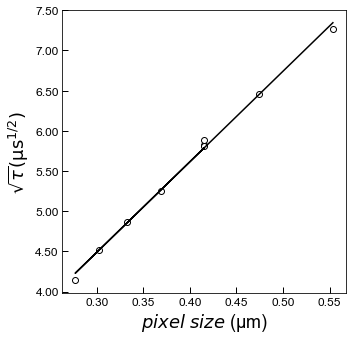

<Figure size 432x288 with 0 Axes>

In [13]:
fig = p.set_figure("%0.2f", "%0.2f")


x = np.array(vox)*1e6
mask = x<0.6
y = np.sqrt((np.array(taus)*1e6))
x = x[mask]
y=y[mask]
yreg, a, b, res = regression_affine(x, y, details=True)
plt.plot(x,y ,  marker = "o", markeredgecolor="k", color = "w")

plt.plot(x,yreg, "k")

plt.ylabel(r"$\sqrt{\tau} (\mathrm{µs^{1/2}})$")
plt.xlabel("$pixel$ $size$ (µm)")
p.save_name = "confocal_ENS_pixel_size"
u = p.saving(fig)
a

## Power (57:)

array([24.77013162])

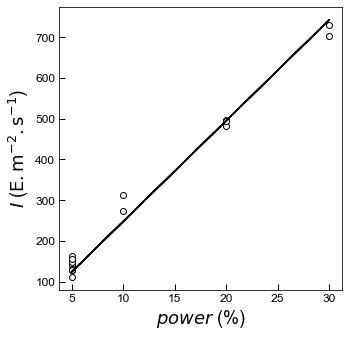

<Figure size 432x288 with 0 Axes>

In [117]:
fig = p.set_figure("%d", "%d")
x = np.array(inty)
y = 1/(np.array(taus)*sigma_480)
yreg, a, res = regression_linear(x, y, details=True)
plt.plot(x,y ,  marker = "o", markeredgecolor="k", color = "w")

plt.plot(x,yreg, "k")

plt.ylabel(r"$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)")
plt.xlabel("$power$ (%)")
p.save_name = "confocal_ENS1_power_var"
u = p.saving(fig)
a

In [65]:
H

128

Text(0, 0.5, 'tau')

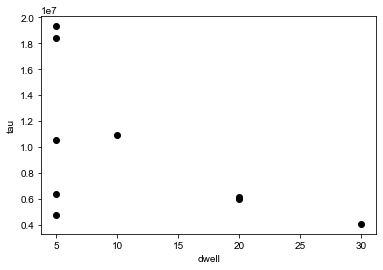

In [157]:
#fig = p.set_figure("%d", "%0.2f")
plt.plot(np.array(inty), (np.array(taus)*1e6), "ok")
#plt.ylim(2, 5)
#plt.xlim(0, 10)
plt.xlabel("dwell")
plt.ylabel("tau")

Text(0, 0.5, '1/tau (µs)')

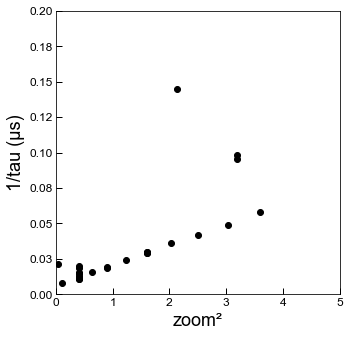

In [47]:
fig = p.set_figure("%d", "%0.2f")
plt.plot(np.array(zoom)**2/inty, 1/(np.array(taus)*1e6), "ok")
plt.ylim(0, 0.2)
plt.xlim(0, 5)
plt.xlabel("zoom²")
plt.ylabel("1/tau (µs)")

Text(0.5, 0, 'dx (µm)')

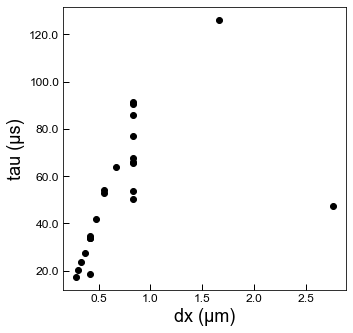

In [73]:
fig = p.set_figure("%0.1f", "%0.1f")
plt.plot(np.array(vox)*1e6, np.array(taus)*1e6, "ok")
#plt.ylim(2, 5)
#plt.xlim(0, 10)
plt.ylabel("tau (µs)")
plt.xlabel("dx (µm)")

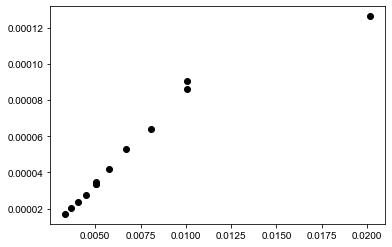

In [14]:
plt.plot(np.array(vox)/np.array(dwell_time)/np.array(inty), np.array(taus), "ok")


Text(0, 0.5, 'tau (µs)')

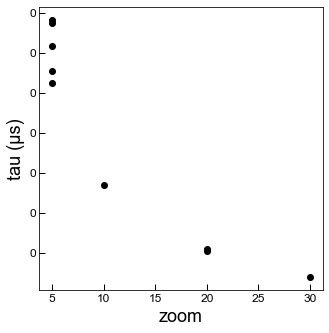

In [35]:
fig = p.set_figure("%d", "%d")
plt.plot(np.array(inty), np.array(taus), "ok")
plt.xlabel("zoom")
plt.ylabel("tau (µs)")

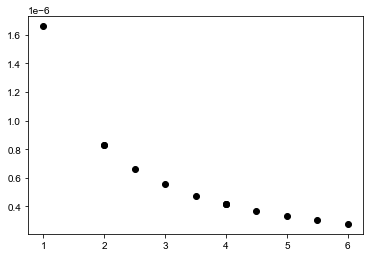

In [26]:
plt.plot(np.array(zoom), np.array(vox), "ok")


Text(0, 0.5, 'dx')

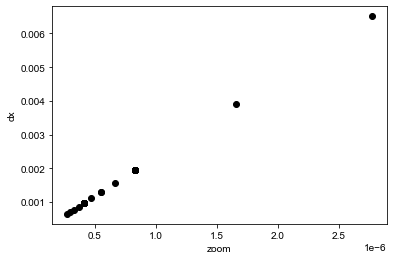

In [136]:
#fig = p.set_figure("%0.02f", "%0.02f")
plt.plot(np.array(vox), 1/(np.array(zoom)*np.array(Hs)), "ok")
#plt.plot(np.array(zoom), np.array(vox)*1e6, "ok")

plt.xlabel("zoom")
plt.ylabel("dx")

In [131]:
Hs

[256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128]